Please note that this notebook was originally ran on kaggle and downloaded afterward, so the current paths are not correct for re-running.<br>
To run it, please comment the kaggle paths and uncomment the paths below them.

**credit**: boilerplate finetuning code in this notebook is adapted from the official pytorch tutorial which can be found at https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/caltech101/Caltech101'
# data_dir = 'data/Caltech101'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'eval', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'eval', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(class_names)

cuda:0
['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', '

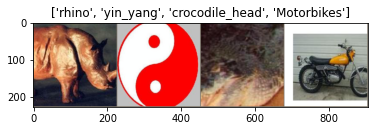

In [4]:
# visual a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs, classes = next(iter(dataloaders['train']))    # Get a batch of training data
out = torchvision.utils.make_grid(inputs)            # Make a grid from batch
imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'eval':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['eval']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return model.train(mode=was_training)

## Finetuning

In [10]:
model_ft = models.resnet18()
model_ft.load_state_dict(torch.load('/kaggle/input/pretrained-pytorch/resnet18-5c106cde.pth'))
# model_ft.load_state_dict(torch.load('./resnet18-5c106cde.pth'))
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_ft, ft_acc_hist, ft_loss_hist = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4974 Acc: 0.4391
eval Loss: 0.9205 Acc: 0.7244

Epoch 1/24
----------
train Loss: 1.5313 Acc: 0.6152
eval Loss: 0.6128 Acc: 0.8110

Epoch 2/24
----------
train Loss: 1.2711 Acc: 0.6754
eval Loss: 0.5119 Acc: 0.8463

Epoch 3/24
----------
train Loss: 1.1105 Acc: 0.7118
eval Loss: 0.4546 Acc: 0.8683

Epoch 4/24
----------
train Loss: 1.0266 Acc: 0.7348
eval Loss: 0.5773 Acc: 0.8378

Epoch 5/24
----------
train Loss: 0.9900 Acc: 0.7363
eval Loss: 0.4375 Acc: 0.8683

Epoch 6/24
----------
train Loss: 0.9389 Acc: 0.7564
eval Loss: 0.4786 Acc: 0.8707

Epoch 7/24
----------
train Loss: 0.7082 Acc: 0.8179
eval Loss: 0.4206 Acc: 0.8756

Epoch 8/24
----------
train Loss: 0.6285 Acc: 0.8397
eval Loss: 0.3498 Acc: 0.8976

Epoch 9/24
----------
train Loss: 0.5622 Acc: 0.8583
eval Loss: 0.3275 Acc: 0.9012

Epoch 10/24
----------
train Loss: 0.5571 Acc: 0.8617
eval Loss: 0.3379 Acc: 0.9012

Epoch 11/24
----------
train Loss: 0.5340 Acc: 0.8606
eval Loss: 0.3334 Acc

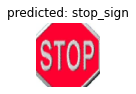

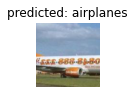

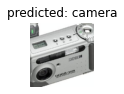

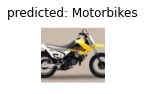

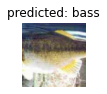

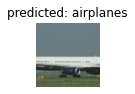

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor （abandoned）

In [15]:
model_ll = models.resnet18()
model_ll.load_state_dict(torch.load('/kaggle/input/pretrained-pytorch/resnet18-5c106cde.pth'))
# model_ll.load_state_dict(torch.load('./resnet18-5c106cde.pth'))
for param in model_ll.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ll.fc.in_features
model_ll.fc = nn.Linear(num_ftrs, len(class_names))

model_ll = model_ll.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_ll = optim.SGD(model_ll.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ll, step_size=7, gamma=0.1)

In [16]:
model_ll, ll_acc_hist, ll_loss_hist = train_model(model_ll, criterion, optimizer_ll, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.8812 Acc: 0.3794
eval Loss: 1.1280 Acc: 0.7159

Epoch 1/24
----------
train Loss: 1.8380 Acc: 0.5724
eval Loss: 0.7188 Acc: 0.7756

Epoch 2/24
----------
train Loss: 1.4914 Acc: 0.6420
eval Loss: 0.7433 Acc: 0.7720

Epoch 3/24
----------
train Loss: 1.3313 Acc: 0.6821
eval Loss: 0.5562 Acc: 0.8183

Epoch 4/24
----------
train Loss: 1.2050 Acc: 0.7056
eval Loss: 0.5260 Acc: 0.8268

Epoch 5/24
----------
train Loss: 1.1124 Acc: 0.7285
eval Loss: 0.4787 Acc: 0.8463

Epoch 6/24
----------
train Loss: 1.1114 Acc: 0.7179
eval Loss: 0.4849 Acc: 0.8427

Epoch 7/24
----------
train Loss: 0.9965 Acc: 0.7580
eval Loss: 0.5109 Acc: 0.8341

Epoch 8/24
----------
train Loss: 0.9506 Acc: 0.7627
eval Loss: 0.5228 Acc: 0.8354

Epoch 9/24
----------
train Loss: 0.9592 Acc: 0.7644
eval Loss: 0.4787 Acc: 0.8378

Epoch 10/24
----------
train Loss: 0.9744 Acc: 0.7658
eval Loss: 0.4336 Acc: 0.8549

Epoch 11/24
----------
train Loss: 0.9630 Acc: 0.7632
eval Loss: 0.4505 Acc

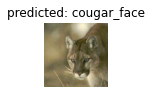

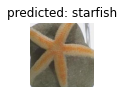

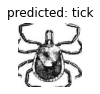

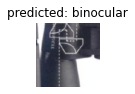

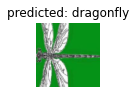

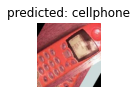

In [18]:
visualize_model(model_ll)
plt.ioff()
plt.show()

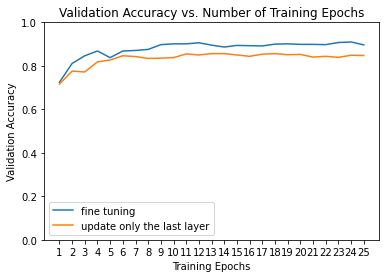

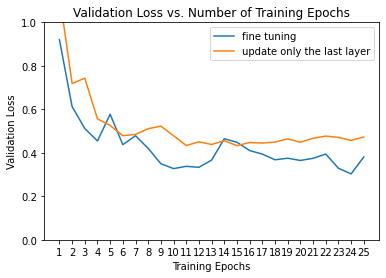

In [32]:
# Plot validation accuracy vs. number of training epochs for the transfer learning method and
#  the model trained from scratch

ft_acc_hist0 = [float(h) for h in ft_acc_hist]
ft_loss_hist0 = [float(h) for h in ft_loss_hist]
ll_acc_hist0 = [float(h) for h in ll_acc_hist]
ll_loss_hist0 = [float(h) for h in ll_loss_hist]
num_epochs=25
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1), ft_acc_hist0, label="fine tuning")
plt.plot(range(1,num_epochs+1), ll_acc_hist0, label="update only the last layer")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1), ft_loss_hist0, label="fine tuning")
plt.plot(range(1,num_epochs+1), ll_loss_hist0, label="update only the last layer")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [34]:
PATH = '/kaggle/working/model_ft.pth'
torch.save(model_ft.state_dict(), PATH)

In [35]:
PATH = '/kaggle/working/model_ll.pth'
torch.save(model_ll.state_dict(), PATH)

## test using model_ft

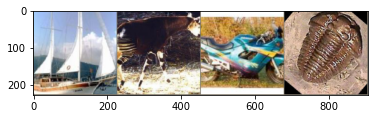

GroundTruth:  ketch okapi Motorbikes trilobite


In [37]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [40]:
images = images.to(device)
outputs = model_ft(images)
_, predicted = torch.max(outputs, 1) # 每行最大的值的位置
print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(4)))

Predicted:  ketch okapi Motorbikes trilobite


In [41]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['test']:
#         inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
#         print(labels) # batch = labels.size = 4
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the model on test images: %d %%' % (100 * correct / total))

Accuracy of the model on test images: 90 %


In [99]:
num_classes = len(class_names)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
count = 0
with torch.no_grad():
    for data in dataloaders['test']:
#         images, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze() # 去除size为1的维度
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        count += 1
        if count % 99 == 1:
            print('still testing...')

acc_dic = {}
for i in range(num_classes):
    acc = 100 * class_correct[i] / class_total[i]
    acc_dic[class_names[i]] = acc
    print('Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

still testing...
still testing...
still testing...
still testing...
still testing...
Accuracy of Faces : 98 %
Accuracy of Faces_easy : 55 %
Accuracy of Leopards : 100 %
Accuracy of Motorbikes : 100 %
Accuracy of accordion : 100 %
Accuracy of airplanes : 98 %
Accuracy of anchor : 50 %
Accuracy of   ant : 100 %
Accuracy of barrel : 88 %
Accuracy of  bass : 60 %
Accuracy of beaver : 77 %
Accuracy of binocular : 100 %
Accuracy of bonsai : 96 %
Accuracy of brain : 100 %
Accuracy of brontosaurus : 100 %
Accuracy of buddha : 100 %
Accuracy of butterfly : 94 %
Accuracy of camera : 90 %
Accuracy of cannon : 62 %
Accuracy of car_side : 100 %
Accuracy of ceiling_fan : 88 %
Accuracy of cellphone : 90 %
Accuracy of chair : 50 %
Accuracy of chandelier : 95 %
Accuracy of cougar_body : 66 %
Accuracy of cougar_face : 92 %
Accuracy of  crab : 71 %
Accuracy of crayfish : 64 %
Accuracy of crocodile : 70 %
Accuracy of crocodile_head : 70 %
Accuracy of   cup : 100 %
Accuracy of dalmatian : 100 %
Accuracy of

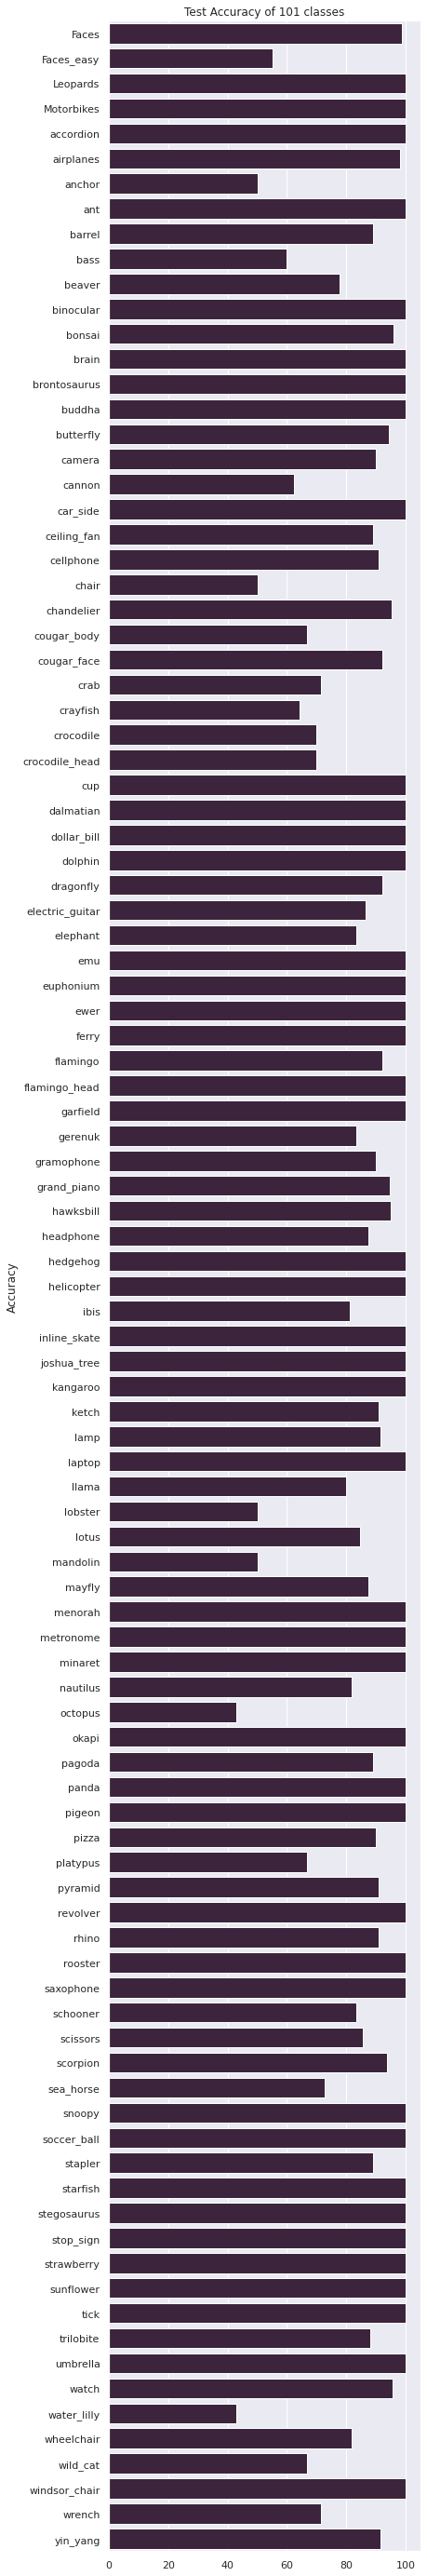

In [98]:
import seaborn as sns
fig = plt.figure(figsize=(6,50))
y = list(acc_dic.keys())
x = list(acc_dic.values())
sns.barplot(x, y, color = (0.25,0.13,0.25),orient='h')
plt.ylabel("Accuracy")
plt.title("Test Accuracy of 101 classes")
plt.show;